In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.layers import Dropout, GRU, Dense, Conv1D, Flatten
from keras import regularizers
from keras.models import Sequential
import matplotlib.pyplot as plt

2023-07-17 10:39:55.387466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-17 10:39:55.476204: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/p

In [26]:
# Define the function for calculating SMA
def SMA(data, window_size):
    return data['Close'].rolling(window=window_size).mean()

# Define the function for calculating EMA
def EMA(data, window_size):
    return data['Close'].ewm(span=window_size).mean()

# Define the function for calculating MACD
def MACD(data, short_window, long_window):
    short_EMA = EMA(data, short_window)
    long_EMA = EMA(data, long_window)
    return short_EMA - long_EMA

# Define the function for calculating RSI
def RSI(data, window_size):
    delta = data['Close'].diff()
    delta = delta[1:] 
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ema_up = up.ewm(com=window_size-1 , min_periods=window_size).mean()
    ema_down = down.ewm(com=window_size-1 , min_periods=window_size).mean()
    return ema_up/ema_down

# Define the function for calculating Bollinger Bands
def Bollinger_Bands(data, window_size):
    middle_band = SMA(data, window_size)
    std_dev = data['Close'].rolling(window=window_size).std()
    upper_band = middle_band + (std_dev*2)
    lower_band = middle_band - (std_dev*2)
    return upper_band, lower_band

def create_sequences(data, seq_length):
    xs = []
    ys = []
    
    for i in range(len(data) - seq_length - 1):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[(i+seq_length)]['Close']
        xs.append(x)
        ys.append(y)
        
    return np.array(xs), np.array(ys)

def gain(x):
    return ((x > 0) * x).sum()

def loss(x):
    return ((x < 0) * x).sum()

def MFI(data, n=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    volume = data['Volume']
    typical_price = (high + low + close)/3
    money_flow = typical_price * volume
    mf_sign = np.where(typical_price > typical_price.shift(1), 1, -1)
    signed_mf = money_flow * mf_sign
    mf_avg_gain = signed_mf.rolling(n).apply(gain, raw=True)
    mf_avg_loss = signed_mf.rolling(n).apply(loss, raw=True)
    return (100 - (100 / (1 + (mf_avg_gain / abs(mf_avg_loss))))).to_numpy()

def ATR(data, n=14):
    high = data['High']
    low = data['Low']
    close = data['Close']
    tr = np.amax(np.vstack(((high - low).to_numpy(), (abs(high - close)).to_numpy(), (abs(low - close)).to_numpy())).T, axis=1)
    return pd.Series(tr).rolling(n).mean().to_numpy()

def ForceIndex(data, ndays): 
    FI = pd.Series(data['Close'].diff(ndays) * data['Volume'], name = 'ForceIndex') 
    data = data.join(FI) 
    return data

def EMV(data, ndays): 
    dm = ((data['High'] + data['Low'])/2) - ((data['High'].shift(1) + data['Low'].shift(1))/2)
    br = (data['Volume'] / 100000000) / ((data['High'] - data['Low']))
    EMV = dm / br 
    EMV_MA = pd.Series(EMV.rolling(ndays).mean(), name = 'EMV') 
    data = data.join(EMV_MA) 
    return data 


/tmp/ipykernel_2887/2502162033.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


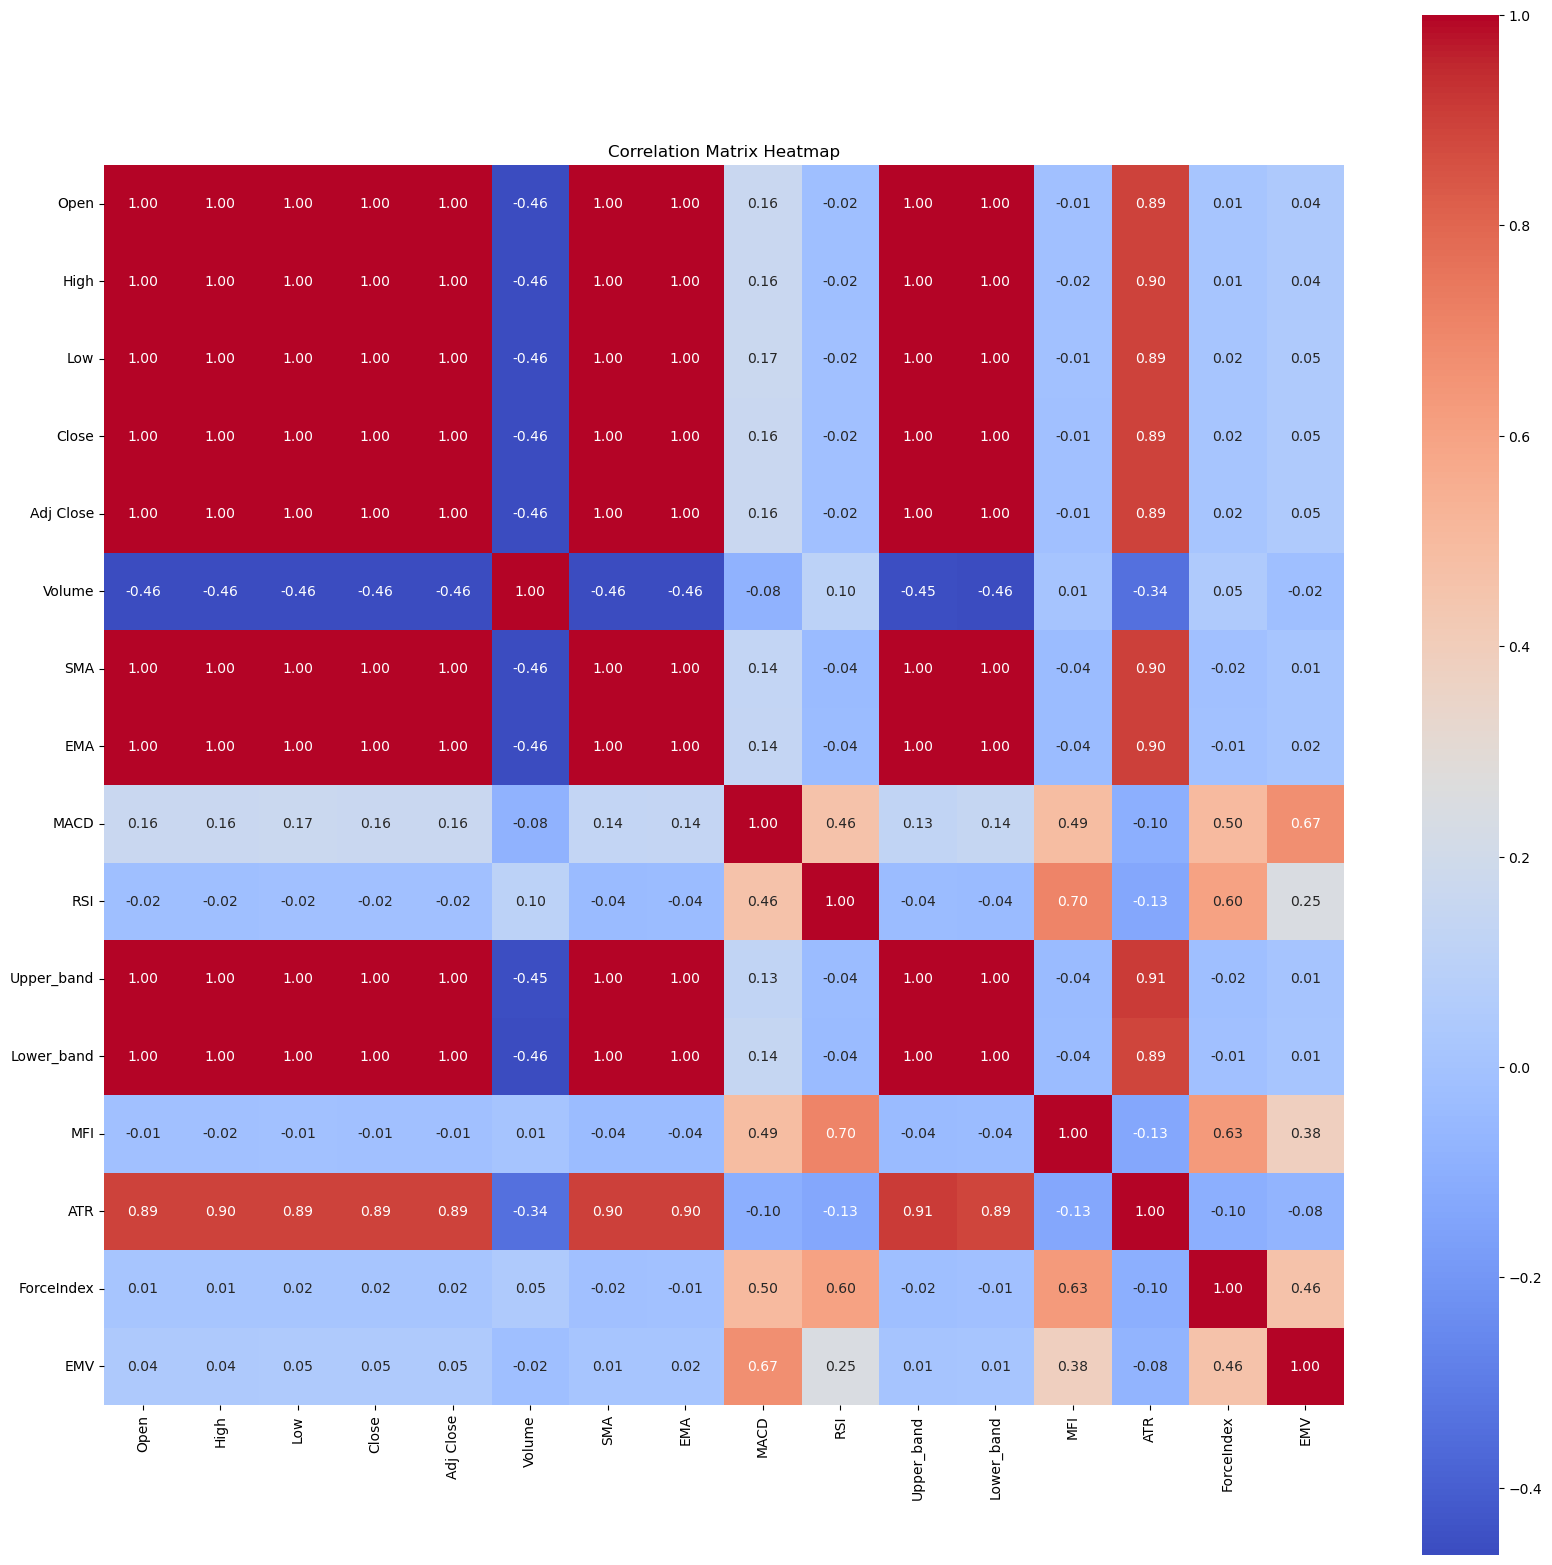

Epoch 1/100
109/109 [==============================] - 5s 20ms/step - loss: 0.0176
Epoch 2/100
109/109 [==============================] - 2s 17ms/step - loss: 0.0025
Epoch 3/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0018
Epoch 4/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0013
Epoch 5/100
109/109 [==============================] - 2s 17ms/step - loss: 0.0013
Epoch 6/100
109/109 [==============================] - 2s 18ms/step - loss: 0.0011
Epoch 7/100
109/109 [==============================] - 2s 19ms/step - loss: 9.0880e-04
Epoch 8/100
109/109 [==============================] - 2s 18ms/step - loss: 9.1668e-04
Epoch 9/100
109/109 [==============================] - 2s 17ms/step - loss: 8.5578e-04
Epoch 10/100
109/109 [==============================] - 2s 17ms/step - loss: 8.2277e-04
Epoch 11/100
109/109 [==============================] - 2s 19ms/step - loss: 9.3809e-04
Epoch 12/100
109/109 [==============================] - 2s 17ms/s

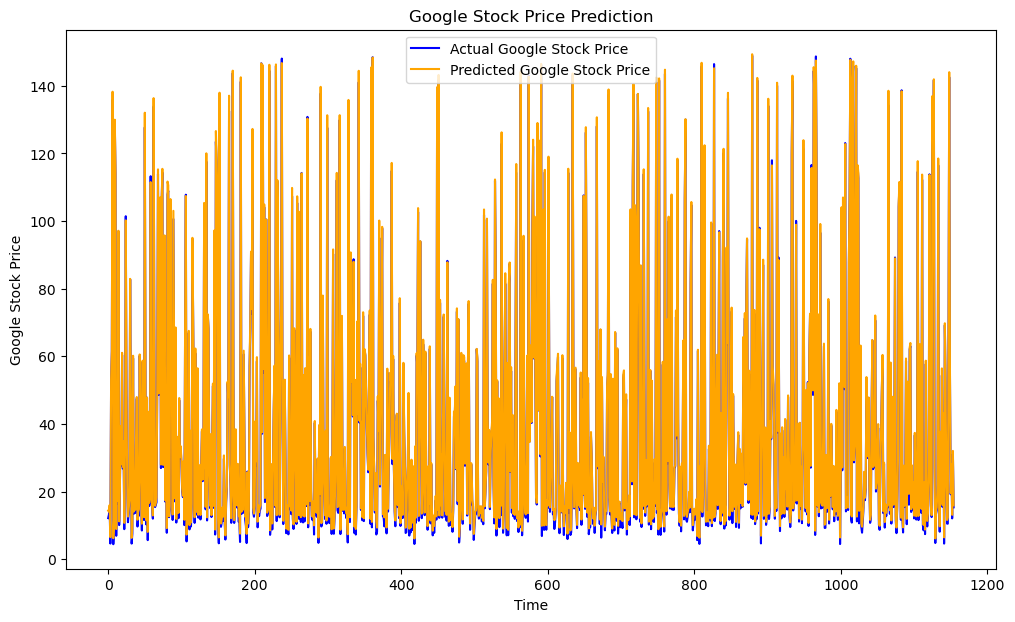

Mean Absolute Error: 1.0119976402877209
Root Mean Squared Error: 1.2205750744310246
37/37 [==============================] - 0s 6ms/step


In [43]:
# Load the data
data = pd.read_csv('GOOGL_large.csv')

# Use techinical indicators to create new features
data['SMA'] = SMA(data, 14)
data['EMA'] = EMA(data, 14)
data['MACD'] = MACD(data, 12, 26)
data['RSI'] = RSI(data, 14)
data['Upper_band'], data['Lower_band'] = Bollinger_Bands(data, 14)
data['MFI'] = MFI(data, 14)
data['ATR'] = ATR(data, 14)
data['ForceIndex'] = ForceIndex(data, 14)['ForceIndex']
data['EMV'] = EMV(data, 14)['EMV']

corr_matrix = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Preprosessing data
data = data.dropna()
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SMA', 'EMA', 'MACD', 'RSI', 'ATR', 'ForceIndex', 'EMV', 'Upper_band', 'Lower_band']
drop_features = data_scaled.columns.drop(['MFI', 'RSI', 'Volume'])
scaler = MinMaxScaler()
data_scaled = data.copy()
data_scaled[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
X, y = create_sequences(data_scaled, 10)
drop_features = data_scaled.columns.drop(['Close', 'Date'])
X = data_scaled[drop_features]
y = data_scaled['Close']
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Create, train, and evaluate model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

prediction = model.predict(X_test)
close_scaler = MinMaxScaler()
close_scaler.fit(data[['Close']])
predictions = model.predict(X_test)
predictions = close_scaler.inverse_transform(predictions)
y_test_unscaled = close_scaler.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(12,7))
plt.plot(y_test_unscaled, color='blue', label='Actual Google Stock Price')
plt.plot(predictions , color='orange', label='Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

mae = mean_absolute_error(y_test_unscaled.reshape(-1), predictions.reshape(-1))
rmse = math.sqrt(mean_squared_error(y_test_unscaled.reshape(-1), predictions.reshape(-1)))

print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
model.add(Dense(64, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)))

pred_lstm = model.predict(X_test)

predictions = pred_lstm


Epoch 1/100
55/55 [==============================] - 4s 21ms/step - loss: 0.0510
Epoch 2/100
55/55 [==============================] - 1s 19ms/step - loss: 0.0028
Epoch 3/100
55/55 [==============================] - 1s 18ms/step - loss: 7.2168e-04
Epoch 4/100
55/55 [==============================] - 1s 21ms/step - loss: 5.7741e-04
Epoch 5/100
55/55 [==============================] - 1s 19ms/step - loss: 5.2558e-04
Epoch 6/100
55/55 [==============================] - 1s 18ms/step - loss: 4.3887e-04
Epoch 7/100
55/55 [==============================] - 1s 18ms/step - loss: 5.1491e-04
Epoch 8/100
55/55 [==============================] - 1s 18ms/step - loss: 4.3586e-04
Epoch 9/100
55/55 [==============================] - 1s 18ms/step - loss: 4.9370e-04
Epoch 10/100
55/55 [==============================] - 1s 19ms/step - loss: 4.7526e-04
Epoch 11/100
55/55 [==============================] - 1s 19ms/step - loss: 4.8534e-04
Epoch 12/100
55/55 [==============================] - 1s 18ms/step - lo

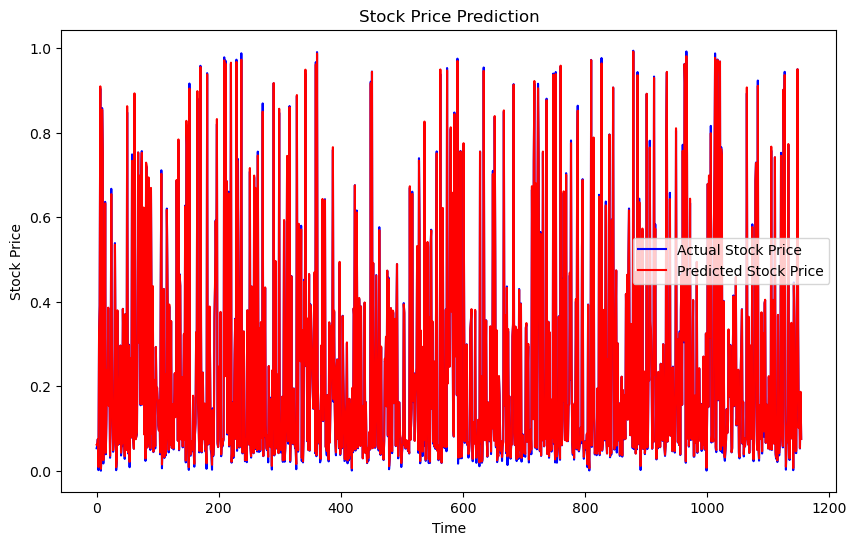

In [45]:
# Define GRU model
gru_model = Sequential()
gru_model.add(GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
gru_model.add(GRU(50, return_sequences=False))
gru_model.add(Dense(25))
gru_model.add(Dense(1))

# Compile and fit GRU model
gru_model.compile(optimizer='adam', loss='mean_squared_error')
gru_model.fit(X_train, y_train, batch_size=64, epochs=100)

# Define 1D CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

# Compile and fit 1D CNN model
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
cnn_model.fit(X_train, y_train, batch_size=64, epochs=100)

pred_lstm = model.predict(X_test)
pred_gru = gru_model.predict(X_test)
pred_cnn = cnn_model.predict(X_test)
predictions = (pred_lstm + pred_gru + pred_cnn) / 3

y_train_2d = y_train.reshape(-1, 1)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train_2d)

print(predictions)

predictions_unscaled = scaler_y.inverse_transform(predictions.reshape(-1, 1))
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1))

print(predictions_unscaled)

mae = mean_absolute_error(y_test_unscaled, predictions_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions_unscaled))

print('Mean Absolute Error:', mae)
print('Root Mean Squared Error:', rmse)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_unscaled, color='blue', label='Actual Stock Price')
plt.plot(predictions_unscaled, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()